# (2) 고객 군집 분석 | 광고 프로모션 효율 증진을 위한 커머스 고객 세분화 | 파이썬 머신러닝

데이터의 차원(컬럼)이 많을 수록 고객을 분류할 기준을 찾기가 복잡해집니다. 사람의 머리로는 4차원 이상의 데이터는 상상하기 어렵고 시각화 차트로 분포를 확인할 수도 없습니다. 이런 상황에서 머신러닝은 차원 수가 많더라도 그들 관계에 대한 가장 설명력이 높은 최적의 패턴을 찾아내는데, X와 Y를 연결하는 복잡한 식을 찾아낼 때도 사용되지만 X라는 집단을 x_a, x_b, x_c 등으로 세분화하는 임의의 기준을 발견하기 위해서도 사용됩니다. 후자를 군집 분석이라 하며 대표적으로 K-means 알고리즘이 다양한 분야에서 활용됩니다.

이번 장에서는 고객을 2개 그룹으로 분류해보면서 사람이 임의로 기준을 나누는 것과 머신러닝을 사용하는 방식의 차이를 살펴볼 것입니다.

```
목차
___
Step 2. 고객 그룹 세분화
     2-1. 나이에 따라 분류하기
     2-2. 최근 구매일자에 따라 분류하기
     2-3. 가입 기간에 따라 분류하기
     2-4. 컴플레인 여부에 따라 분류하기
     2-5. 온/오프라인 선호도에 따라 분류하기
     2-6. 프로모션 동의 여부에 따라 분류하기
     2-7. 머신러닝으로 분류하기
```

## Step 2. 고객 그룹 세분화

`Step 1`에서 군집 분석에 들어가기 전, 현실 상황을 가정하기 위해 일부 컬럼을 제거하고 age컬럼의 이상치를 조정하는 등 필요한 전처리를 끝냈습니다. 이번 Step 2에서는 고객을 다양한 방식으로 세분화할 예정이며 이를 위해 필요한 파이썬 라이브러리와 이전 장에서 저장한 데이터를 다시 불러옵니다.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
customer_df = pd.read_csv('./data/customer.csv')

customer_df

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,promo1,promo2,complain,promo6,age,period
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543
3,6182,26,2,2,0,4,6,0,0,0,0,0,0,0,32,136
4,5324,94,5,5,3,6,5,0,0,0,0,0,0,0,35,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,2,9,3,4,5,0,0,0,0,0,0,0,49,612
2236,4001,56,7,8,2,5,7,0,0,0,1,0,0,0,70,132
2237,7270,91,1,2,3,13,6,0,1,0,0,0,0,0,35,386
2238,8235,8,2,6,5,10,3,0,0,0,0,0,0,0,60,387


### 1-1. 나이에 따라 분류하기

가장 먼저 생각해볼 수 있는 분류 기준은 '나이'입니다. 일반적으로 인적 정보 중에서도 '나이'는 가장 정규분포와 가까운 형태를 보이며, 그룹화를 위한 주요 기준이 됩니다. 특히 커머스 시장에서는 제품을 소싱하거나 광고문구를 제작할때부터 어떤 나이대의 고객을 타겟으로 할 것인지 1순위로 고려하기 때문에 '나이'는 매우 중요한 컬럼입니다.

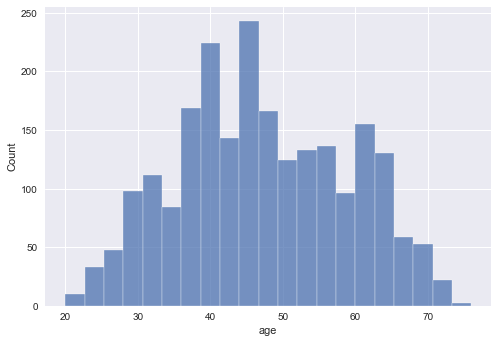

In [4]:
plt.style.use('seaborn')
sns.histplot(customer_df['age'])
plt.show()

50세 정도를 기준으로 2개 그룹으로 나눌 수 있을 것 같습니다. 총 2240명 중 1120번째 고객의 나이를 확인해보고 약 절반을 나눌 수 있는 해당 나이대를 기준 값으로 선택합니다.

In [5]:
customer_df['age'].sort_values()[:1120]

1170    20
46      20
2213    21
747     21
1850    21
        ..
1668    46
1477    46
36      46
2045    46
467     46
Name: age, Length: 1120, dtype: int64

46세 이하 고객을 B-a그룹, 46세가 넘는 고객을 B-b그룹에 포함시킬 수 있습니다.

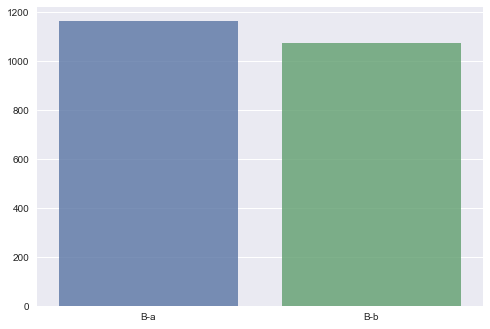

In [9]:
# 46세 이하 그룹은 B-a로, 46세 초과 그룹은 B-b로 표기하여 over_46이라는 새로운 변수에 담는다.
over_46 = customer_df['age'].apply(lambda x : 'B-a' if x <= 46 else 'B-b')

# B-a그룹에 몇명, B-b그룹에 몇명이 있는지에 대한 정보를 담은 시리즈 데이터를 counts_46에 담는다.
counts_46 = over_46.value_counts()
# counts_46의 인덱스(B-a, B-b)를 x축으로 하고 값(B-a,B-b 각각 갯수)을 y축에 표현한다.
sns.barplot(x=counts_46.index, y=counts_46.values, alpha=0.8);


이렇게 적절히 그룹을 나눈 다음 우리가 설계한 프로모션으로 테스트를 진행해볼 수 있습니다. 다만 A/B 테스트를 각 그룹에 적용하는 것이 아니라 A는 기존 방식의 일괄 프로모션을 적용하는 것이고, B는 우리가 분류한 B-a, B-b로 고객을 나눠 각 그룹의 연령대 성향에 맞는 프로모션을 적용하게 됩니다. 이 때문에 그룹명을 B-a, B-b로 설정했습니다.

### 1-2. 최근 구매일자에 따라 분류하기

광고, 프로모션은 피로도 관리가 매우 중요합니다. 따라서 최근에 구매한 고객이라면 연이어 프로모션을 진행하는 것보다 구매 기간이 상당일 지난 고객에게만 프로모션을 별도로 제공하는 것이 효율이 좋을 수도 있습니다. (물론 아닐 수도 있습니다. 그렇기 때문에 정책을 즉시 바꾸기 전에 이렇게 가정을 하고 실험을 하는 것입니다.)

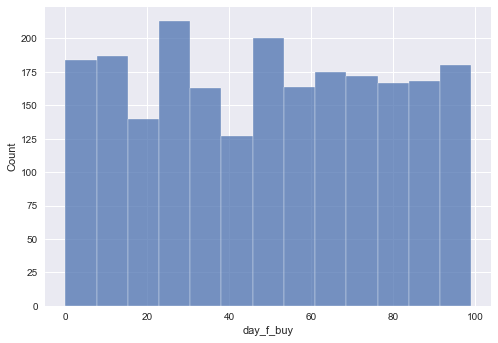

In [10]:
# 최근 구매 이후 구매가 발생하지 않은 일수(날짜)별 고객 분포를 확인한다.
sns.histplot(customer_df['day_f_buy']);

마찬가지로 고객은 B-a, B-b 2개 그룹으로 나눈다.(3개 이상의 그룹으로 나눌 수 있습니다. 동일한 방식으로 할 수 있으며 논의를 단순화하기 위해 2개 그룹으로만 계속해서 실습을 진행하겠습니다.)

그 기준은 역시 구매하지 않은 기간(day_f_buy)을 날짜순으로 나열했을 때 1120번째 고객의 데이터로 정합니다.

In [11]:
customer_df['day_f_buy'].sort_values()[:1120]

66       0
551      0
347      0
23       0
391      0
        ..
1670    49
1257    49
435     49
1624    49
1282    49
Name: day_f_buy, Length: 1120, dtype: int64

최근 구매일로부터 50일이 지나지 않은(0일~49일) 고객들을 B-a 그룹, 50일을 초과한 고객들을 B-b 그룹으로 설정하고, 분포를 확인해보면 아래와 같습니다.

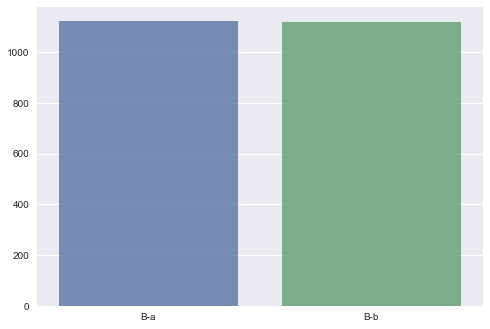

In [14]:
# 50일이 지나지 않은 고객 -> B-a, 50일 지난 고객 -> B-b
over_50 = customer_df['day_f_buy'].apply(lambda x : 'B-a' if x < 50 else 'B-b')

# B-a그룹에 몇명, B-b그룹에 몇명이 있는지에 대한 정보를 담은 시리즈 데이터를 counts_50에 담는다.
counts_50 = over_50.value_counts()
# counts_50의 인덱스(B-a, B-b)를 x축으로 하고 값(B-a,B-b 각각 갯수)을 y축에 표현한다.
sns.barplot(x=counts_50.index, y=counts_50.values, alpha=0.8)
plt.show()

'age' 컬럼에 비해 더 유사한 비율의 분포를 확인할 수 있습니다. 각 그룹에 정확히 몇 명씩 포함되어 있는지 확인하고 이어서 다른 컬럼도 분석해보겠습니다.

In [15]:
counts_50

B-a    1122
B-b    1118
Name: day_f_buy, dtype: int64

### 1-3. 가입 기간에 따라 분류하기

일반적으로 서비스 가입 기간은 정규분포를 따르지 않습니다. 따라서 가입 기간별로 고객 그룹을 나누게 되면 연도별로 나누거나 특정 파트(기능) 런칭일을 기준일로 하게 됩니다. 그러나 우리가 분석하려는 서비스의 경우 고객들이 이탈하고 있는 '문제상황'이 존재하기 때문에 최근 가입자 수가 줄어들고 있을 가능성이 큽니다. 

다시 말해 전체 사용자 수는 늘고 있다 하더라도 최근 가입자 수가 정체되거나 줄어들고 있다면 초기부터 중기(문제상황 시작)까지 가입자 수가 늘다가 중기부터 가입자 수가 줄어드는 정규분포 형태를 띌 수 있습니다. 다행히 아래 차트를 보면 우리의 예상과 일치함을 알 수 있습니다.

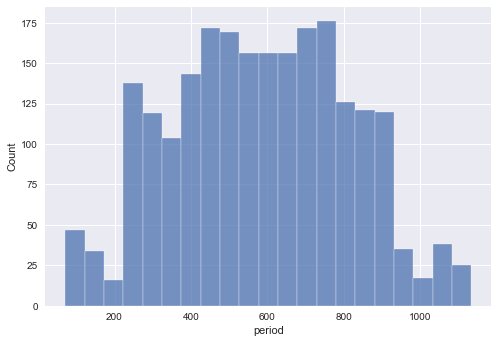

In [17]:
sns.histplot(customer_df['period'])
plt.show()

데이터를 분석하다보면 이렇게 정규분포와 가까운 형태를 찾게 됩니다. 실무 상황을 생각해보면 2240건의 데이터에서 이러한 형태라면 실무 데이터를 직접 확인했을 때 정규성 검사를 통과할 확률이 큽니다. 이 경우 상관분석, 회귀분석 등 다양한 통계기법들을 사용해볼 수 있습니다. 따라서 데이터 분석을 실제로 수행하기에 앞서 데이터가 정규분포를 띄는지, 독립 변수간 상관성이 있는지 등 다양한 검정 후에 본격적으로 분석을 수행하게 됩니다.(물론 여건상 실험 환경이 이론과 같은 정제된 환경이 아니기 때문에 모든 상황에서 그런 것은 아닙니다.)

아무튼 본론으로 돌아와서 '가입기간' 역시 신규고객, 기존고객 정도로 나눠볼 수 있겠습니다. 여기서 신규 고객을 아주 최근에 가입한 고객으로 생각하기 보다 어떤 문제지점(표에서 볼 때 가입자 수가 가장 많았던 600~500일 지점) 이후와 이전으로 생각해봅니다. 이번에도 고객을 가입기간으로 절반 가량 분류하고 분포를 확인해보겠습니다.

In [18]:
customer_df['period'].sort_values()[:1120]

2003     71
50       72
288      72
2155     72
88       72
       ... 
1537    583
1293    583
327     584
2005    584
1974    584
Name: period, Length: 1120, dtype: int64

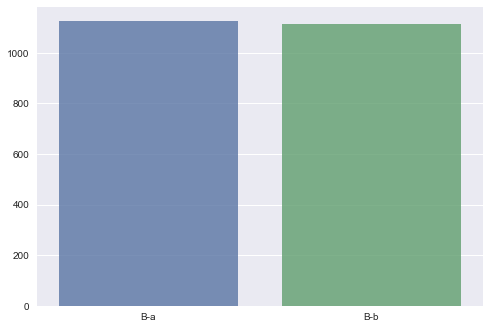

In [19]:
# 가입기간 0일~584일 지난 고객 -> B-a, 가입한지 584일이 넘은 고객 -> B-b
over_584 = customer_df['period'].apply(lambda x : 'B-a' if x <= 584 else 'B-b')

# B-a그룹에 몇명, B-b그룹에 몇명이 있는지에 대한 정보를 담은 시리즈 데이터를 counts_584에 담는다.
counts_584 = over_584.value_counts()
# counts_50의 인덱스(B-a, B-b)를 x축으로 하고 값(B-a,B-b 각각 갯수)을 y축에 표현한다.
sns.barplot(x=counts_584.index, y=counts_584.values, alpha=0.8);


이번에도 고객이 잘 분류된 것 같습니다. 정확한 숫자를 확인해보고 다음 컬럼을 살펴봅니다.

In [20]:
counts_584

B-a    1125
B-b    1115
Name: period, dtype: int64

### 1-4. 컴플레인 여부에 따라 분류하기

컴플레인을 한 경험이 있는 고객과 그렇지 않은 고객은 명백한 경계가 존재합니다. 곧 이탈할 것만 같은 고객에게는 강도 높은 프로모션을 제공하여 충성고객으로 돌아서게 만들 수 있습니다. 그러나 데이터 분석가가 이렇게 실험을 해야 하는 상황까지 왔다면 컴플레인 같은 현업의 눈에 띄는 마이너스 포인트가 애초에 없었을 가능성이 큽니다. 현업에서 혹은 기존 실무 관점에서 원인을 찾기 어려우니 데이터를 분석하는 단계로 넘어가게 됩니다. 

In [21]:
customer_df['complain'].value_counts()

0    2219
1      21
Name: complain, dtype: int64

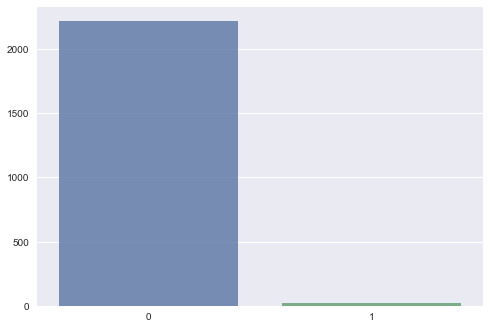

In [23]:
count_complain = customer_df['complain'].value_counts()

sns.barplot(x=count_complain.index, y=count_complain.values, alpha=0.8)
plt.show()

안타깝게도 예상했듯이 컴플레인이 약 1% 수준으로, 겉으로 볼 때는 매우 양호한 서비스입니다. 평점으로 생각해보면 5점 만점에 4.9입니다. 그래서 아무 문제가 없어보이는데 이탈하는 것이 너무 이상하기 때문에 이렇게 우리가 가설을 세우고 A/B테스트를 설계하고 테스트에 포함시킬 그룹을 정의하고 있는 것입니다. 

이렇게 고객을 분류했을 때 불균형이 심하다면 A/B테스트는 적절하지 않습니다. 컴플레인을 한 21명의 고객과 나머지 1998명의 고객을 각 그룹으로 묶어서 A/B 테스트를 진행하는 것보다 21명의 고객에게 할인 쿠폰을 발급한다거나 유입률이 좋은 고효율 프로모션을 별도로 제공하는 것이 시간과 비용 모든 측면을 고려했을 때 더 좋은 선택입니다. 1%의 고객을 대상으로 테스트하는 것은 테스트 성과가 성공적이라 하더라도 그것으로부터 얻는 인사이트가 비용 대비 저조하기 때문입니다. 따라서 이 경우에는 해당 고객에게만 별도의 프로모션을 제공하는 것을 추가로 제안해보는 것이 좋겠습니다.

### 1-5. 온/오프라인 선호도에 따라 분류하기

실제로 데이터를 분석하게 되면 컬럼 하나씩 깊게 파고드는 것보다 여러 컬럼을 조합해서 새로운 정보를 취득하는 것이 중요하고, 분석가의 시야와 역량에 따라 조합의 수는 천차만별이기 때문에 다양한 분석 결과들이 나오는 것입니다. 

이번에는 4개 컬럼을 조합해서 간단하지만 중요한 정보를 얻어보고자 합니다. 우리는 고객이 온라인에 익숙한지, 오프라인에 익숙한지 구매 상품의 노출 경로를 통해 확인할 수 있습니다. 다시 말해 오프라인에서(진열대, 전단지) 노출되는 상품을 온라인(온라인광고, 웹사이트 등록)에서 노출되는 상품보다 많이 구매했다면 오프라인을 통해 상품 정보를 많이 획득하는 고객이라는 것입니다. 따라서 해당 고객은 오프라인에 익숙하기 때문에 온라인 프로모션의 효율은 좋지 않을 것이라 예상할 수 있습니다.

이 아이디어를 가지고 고객을 온라인 선호, 오프라인 선호 그룹으로 나눠볼 수 있습니다.

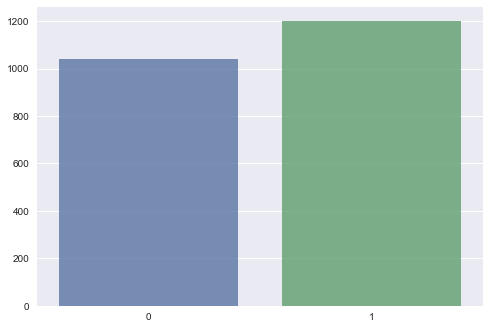

In [25]:
# 오프라인 노출 상품 구매 수 : 오프라인 매장 진열 상품 구매 수 + 전단지 노출 상품 구매 수
counts_buy_offline = customer_df['buy_f_store']+customer_df['buy_f_catalog']
# 온라인 노출 상품 구매 수 : 광고(프로모션) 상품 구매 수 + 웹사이트 표기 상품 구매 수
counts_buy_online = customer_df['buy_f_promo']+customer_df['buy_f_web']

# 오프라인 노출 상품을 온라인 노출 상품보다 많이 구매한 경우 True, 그렇지 않은 경우 False
s = counts_buy_offline > counts_buy_online
# True or False --> 1 or 0 으로 변환
s = s.astype(int)
customer_df['prefer_offline'] = s

# 1, 0 각각 카운트
count_offline = customer_df['prefer_offline'].value_counts()
# 시각화
sns.barplot(x=count_offline.index, y=count_offline.values, alpha=0.8);

위 분포는 오프라인을 선호하는 고객이라면 1이라는 값을 주고, 그렇지 않다면 0이라는 값을 줬습니다. 이번에 B-a, B-b가 아니라 0과 1을 사용한 이유는 코드에서 볼 수 있듯이 새로운 컬럼으로 사용하기 위함입니다. 물론 본 분석에서 새롭게 만든 컬럼을 사용하지는 않겠지만 이렇게 다양한 컬럼의 조합으로 얻어진 정보는 새로운 컬럼으로 추가해주면 또 유용하게 사용할 수 있습니다. 그리고 이 '정보'를 머신러닝을 돌리기 위한 데이터로 사용할 수도 있기 때문에 기계가 이해할 수 있도록 미리 1과 0으로 데이터를 기입해준 것입니다.

다시 돌아와서 이렇게 코드를 통해 온라인 선호 그룹을 0번 그룹, 오프라인 선호 그룹을 1번 그룹으로 나눌 수 있었습니다. 이 그룹을 실제 테스트 그룹(B)으로 활용한다면 온라인 프로모션을 0번 그룹(B-a)에만 진행하고 1번 그룹(B-b)에는 오프라인 전단을 실 거주지에 발송하는 것으로 실험을 진행해볼 수 있습니다. 일괄적으로 온라인 프로모션을 해오던 방식(A)과 결과를 비교해보고 이를 통해 실제 정책에 적용 여부를 판단합니다.

### 1-6. 프로모션 동의 여부에 따라 분류하기

이번에도 `1-5`와 마찬가지로 여러 컬럼을 조합해서 정보를 얻어보겠습니다. 

우리가 분석하고 있는 데이터를 보면 promo1부터 promo6까지 각 프로모션(숫자가 높을 수록 최근 프로모션) 동의 여부가 기록되어 있습니다. 이 데이터들을 고객별로 합산해서 각 고객마다 총 몇 개의 프로모션 발송 동의를 체크했는지 여부를 확인할 수 있습니다.

In [26]:
customer_df.head(3)

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,promo1,promo2,complain,promo6,age,period,prefer_offline
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042,1
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196,0
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543,1


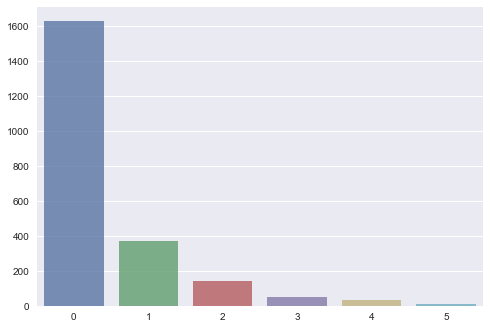

In [28]:
# 각 고객별 프로모션 동의 횟수 총합 계산 후 전체 동의 횟수 카운트
counts_check_promo = customer_df[['promo1','promo2','promo3','promo4','promo5','promo6']].sum(axis=1).value_counts()

# 시각화
sns.barplot(x=counts_check_promo.index, y=counts_check_promo.values, alpha=0.8)
plt.show()

한 번도 동의를 하지 않은(x축 '0' 표기) 그룹의 비중이 너무 높기 때문에 나머지를 하나의 그룹으로 묶어줄 필요가 있습니다. 그리고 우리는 2개 그룹으로만 계속해서 분류하고 있기 때문에 이 방식이 오히려 적절합니다.  

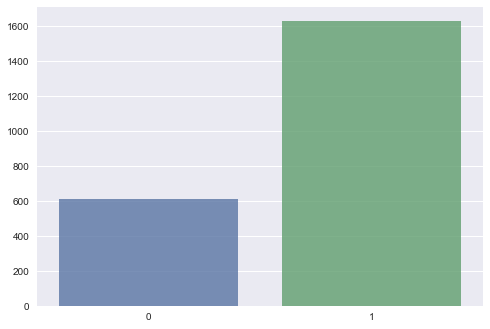

In [29]:
# 한번이라도 동의한사람
check_promo = customer_df[['promo1','promo2','promo3','promo4','promo5','promo6']].sum(axis=1)==0
check_promo = check_promo.astype(int)

count_check_promo_any = check_promo.value_counts()
# 시각화
sns.barplot(x=count_check_promo_any.index, y=count_check_promo_any.values, alpha=0.8)
plt.show()

'1회 이상 동의한 고객'이 약 1600명으로, '한 번도 동의를 하지 않은 고객'보다 2배 이상 많습니다. 물론 여기서 '2번 이상 동의한 고객'과 같이 비율을 수정할 수도 있다. 여기서는 이대로 진행하겠습니다.

우리는 '문제 상황'을 인지하고 다음 프로모션을 어떻게 설계할지 기획하고 있습니다. 다음 프로모션에 '동의'를 한 고객이 1번 그룹(1~6번 프로모션에 1회 이상 동의)에 있다면 기존 프로모션의 할인율은 유지한 채 전달하는 메시지나 스타일을 변경하고, 해당 고객이 0번 그룹(1~6번 프로모션에 동의한 적이 없는 그룹)에 속한다면 할인율 자체를 조정해보는 방식으로 B-a, B-b를 나눌 수 있겠습니다. 이외에도 수많은 아이디어가 존재할 수 있습니다.

### 1-7. 머신러닝으로 분류하기

지금까지 데이터 분포 혹은 몇 가지 컬럼 조합으로 정보를 얻어내서 임의로 고객 집단을 분류해보았습니다. 이번에는 **매우 매우 간단한** 머신러닝을 사용해서 고객을 나눠볼텐데, 머신러닝 알고리즘은 K-Means(K평균)를 사용하겠습니다. K-Means 알고리즘은 우리가 특정한 K개 군집으로 그룹을 나눈다고 생각하면 됩니다. 

In [30]:
# id 컬럼은 사용하지 않기 때문에 잠시 다른 변수에 할당한다.
## (꼭 이렇게 해주지 않아도 괜찮지만 여러 상황에서 이후에 key값으로 사용하게 될 수도 있으니 이렇게 미리 셋팅해주면 편하다.)
id = customer_df['id']

# id 컬럼은 정보를 담고 있는 컬럼이 아닌 key값으로 사용되기 때문에 머신러닝 학습 데이터에서는 제외한다.
data = customer_df.iloc[:,1:]
# 2개 집단으로 분류할 것이다. 머신러닝은 2개 집단의 각 중심점에서 가까운 데이터를 하나의 군집으로 분류해낸다.
kmeans = KMeans(n_clusters=2)
# 각 고객(row)별로 소속 집단(0 or 1)에 대한 정보를 받는다.
labels = kmeans.fit_predict(data)

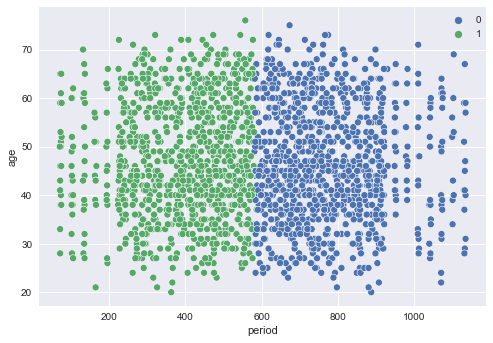

In [38]:
sns.scatterplot(data=data, x='period', y='age', hue=labels)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show()

클러스터는 'period'를 기준으로 그룹을 나눴습니다. 모든 데이터를 입력받았지만 결국 분류 기준을 period로 사용한 것입니다.
확인을 위해 축을 변경해볼 수도 있습니다.

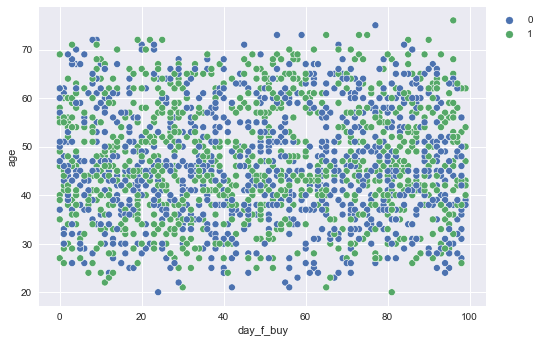

In [37]:
# 나이와 최근 구매일 정보로 시각화
sns.scatterplot(data=data, x='day_f_buy', y='age', hue=labels)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show()

period가 아닌 다른 연속형 변수 조합으로는 패턴을 찾을 수 없습니다. period와 다른 컬럼을 조합하면 아래와 같이 표현됩니다.

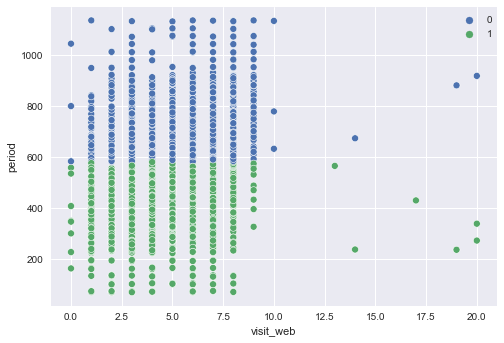

In [40]:
# 웹페이지 방문 수와 가입 기간 정보로 시각화
sns.scatterplot(data=data, x='visit_web', y='period', hue=labels)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show()

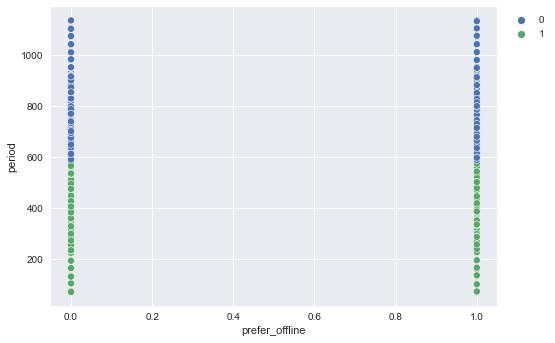

In [41]:
sns.scatterplot(data=data, x='prefer_offline', y='period', hue=labels)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show()

period를 축으로 세우면 다른 컬럼은 period를 기준으로 정확히 분류됩니다. 즉, k-means 알고리즘이 period를 기준으로 고객을 절반씩 분류해낸 것입니다. 어떤가요? 이렇게만 설명하면 머신러닝이 훨씬 편하고 좋은 방법인 것 같습니다. 굳이 분포를 확인하지 않아도 되고, 기계가 찾아낸 패턴이니 왠지 가장 정확한 군집 방식인 것 같습니다. 차원이 복잡하고 많아서 생각하기 골치아프니 머신러닝에게 맡기자! 라는 식으로 접근하면 될 것 같고 그것이 기계가 인간을 위해 해줘야 하는 일인 것 같습니다. 그런데 여기서 잠깐 생각해보면, 저런 패턴이 과연 사람이 찾기 어려운 패턴인가?에 대한 의문을 가질 수 있습니다. 사실 우리도 이미 `1-3`에서 period를 기준으로 집단을 나눈 적이 있고, 머신러닝의 결과와 크게 다르지 않습니다. 오히려 머신러닝은 하나의 패턴만 찾아줬지만 우리는 간단한 분석만으로 6가지의 다양한 분류 패턴을 찾아냈습니다.

또한 이런 접근법(머신러닝에게 맡기자!)에는 치명적인 문제가 있는데, '설명이 불가능하다'는 것입니다. 말 그대로 머신러닝에게 맡겼기 때문에 왜 그런지, 어떤 기준으로 저런 결과가 나온 것인지 분석가가 설명할 수 없습니다. 실무에서 분석은 결국 설명과 설득의 근거를 만들기 위한 과정입니다. 설명할 수 없는 분석은 실무에서 아무런 의미가 없습니다.  '데이터 전부 넣고 기계를 돌려봤더니 이렇게 나왔어요' 라고 할 수는 없는 노릇입니다.

사실, 이번 장에서는 적절하지 않은 머신러닝 사용이 **해석에 오류를 가져오는 예**를 보여주고 싶었습니다.  머신러닝을 직접 분석에 사용해본 적이 없고 글로만 접했다면 앞에서 이상한 부분을 느끼지 못했을 것입니다. 머신러닝을 사용하기 위해서는 도메인 혹은 데이터에 대한 이해가 굉장히 중요하며 데이터를 분석하기 전에 반드시 이러한 이해가 선행되어야 합니다. 머신러닝은 아무 데이터나 들이민다고 알아서 분류하고 예측하고 그룹을 묶어주는 마법이 아닙니다. 어떤 기준으로 분류할지, 어떤 컬럼을 머신러닝의 입력값으로 사용할지 분석가가 사전에 판단해야 합니다.

이번에는 머신러닝을 주도적으로, 적절히 사용하는 과정을 살펴볼 것입니다. 먼저 어떤 기준으로 고객을 분류할 것인지 분석가가 지정해야 합니다. 다양한 기준으로 분석을 해볼 수 있겠지만, 우리는 연속형 변수만 가지고 분석을 해보겠습니다. 프로모션 동의 여부, 컴플레인 여부 등은 그 속에서 복잡한 패턴을 찾을 필요가 없고, 우리가 앞에서 분석했듯이(`1-4`, `1-6`) 단순 집계만으로도 유의미한 인사이트를 얻을 수 있기 때문입니다.

In [42]:
# 연속형 변수 3개만 추출한다.
test_df = customer_df[['day_f_buy','age','period']]
test_df

,day_f_buy,age,period
0,58,59,1042
1,38,62,196
2,26,51,543
3,26,32,136
4,94,35,392
...,...,...,...
2235,46,49,612
2236,56,70,132
2237,91,35,386
2238,8,60,387


다음으로, 머신러닝 모델을 학습시키기 전에 시각화를 해보면 좋습니다. 이전에 직접 분석했던 것처럼 데이터 분포를 눈으로 직접 확인하면서 분석 과정을 추적하는 것은 분석의 주도성을 확보하는 데에 도움이 됩니다. 또한 그렇게 추적해나가야만 머신러닝을 사용해서 집단을 분류해냈을 때 과연 합당한가에 대해 스스로 인지하고 판단할 수 있습니다.

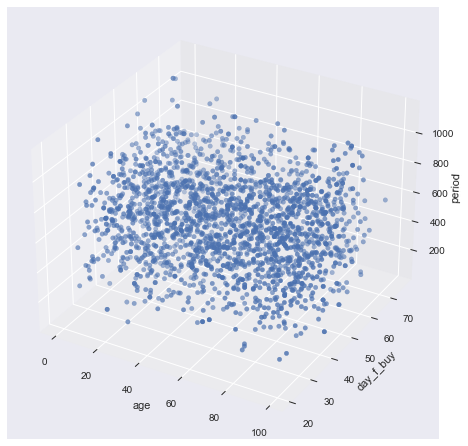

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=test_df['day_f_buy'], ys=test_df['age'], zs=test_df['period'])
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

2240명의 고객은 나이, 최근 구매일로부터 지난 일자, 총 가입 기간에 따라 3차원 데이터로 표현되고 있습니다. 우리는 이 데이터 공간에서 서로 가까운 데이터끼리 2개 그룹으로 나누고싶습니다. 그리고 이 알고리즘을 직접 한땀한땀 구현하기보다 보편적으로 활용되는 k-means 알고리즘을 사용할 것입니다.

In [44]:
# 2개 군집으로 나누는 kmeans 모델 생성
kmeans_new = KMeans(n_clusters=2)
# 연속형 변수만 포함한 데이터로 머신러닝 수행
labels_new = kmeans_new.fit_predict(test_df)

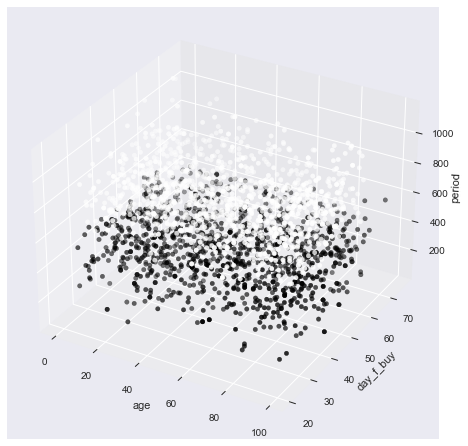

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=test_df['day_f_buy'], ys=test_df['age'], zs=test_df['period'], c=labels_new)
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

k-means 알고리즘을 적용해보니 period가 높은 집단과 낮은 집단으로 나눌 수 있었습니다. 즉, 서로 유사한 데이터 쌍(각 집단의 중심으로부터 가까운)으로 묶으면 period 기준으로 둘로 나눠진다는 것입니다. 그렇다면 period 데이터에 어떤 특성이 기준이 되어서 집단이 분류될 수 있었는지 확인해보겠습니다. 먼저 그 '기준'이 되는 데이터를 찾아봅니다.

In [49]:
# labels 컬럼을 새롭게 만들어준다.
customer_df['labels'] = labels

# labels가 1인 데이터의 분포를 확인한다.
customer_df[customer_df['labels'] == 1]['period'].sort_values()

2003     71
288      72
50       72
88       72
2155     72
       ... 
1251    579
86      579
318     579
1879    580
2209    580
Name: period, Length: 1105, dtype: int64

In [50]:
# labels가 0인 데이터의 분포를 확인한다.
customer_df[customer_df['labels'] == 0]['period'].sort_values()

902      581
913      581
621      581
938      581
445      582
        ... 
1473    1133
724     1134
2194    1134
976     1134
2029    1134
Name: period, Length: 1135, dtype: int64

k-평균 알고리즘은 period가 581 이상인 고객을 하나의 그룹, 581 미만인 고객을 다른 하나의 그룹으로 묶었습니다. 그렇다면 581을 기준으로 고객별 period의 분포가 어떻게 변하는지 확인해봅니다.

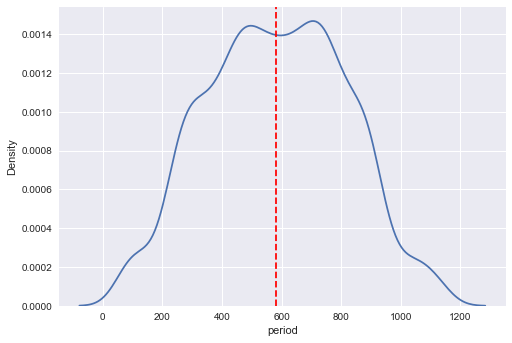

In [51]:
sns.kdeplot(customer_df['period'])
plt.axvline(x=581, c='r', linestyle='--')
plt.show()

위 차트를 통해 가입자 수가 어떻게 변해왔는지 확인할 수 있었습니다. 최근 가입자 수는(period-가입기간 200일 이하) 초기 가입자 수(period-가입기간 1000일 이상)만큼 그 수가 작아졌습니다.(사실 `1-3`에서 이미 확인했다.) 따라서 특정 기점(581일)으로 가입자 수가 급감하고 있기 때문에 이를 기준으로 그룹을 나누는 것이 적합하다고 판단(설명)할 수 있습니다.

머신러닝은 이렇게 우리의 분석에 좋은 도구로 활용될 수 있으며 전적으로 의존하지 않는다면 설명력까지 확보할 수 있습니다. 따라서 분석이 먼저가 된 다음 머신러닝을 조미료처럼 얹어보는 것은 훌륭한 선택이고 더 좋은 머신러닝 알고리즘, 더 높은 머신러닝 성능은 한참 나중에나 필요합니다.

이제 분석을 마무리하면, 우리는 아래와 같이 결론을 내릴 수 있습니다.

고객을 다양한 방식으로 2개 집단으로 나눌 수 있습니다. 그 중에서도 나이, 최근 구매일, 가입 기간을 고려해 가장 동질성이 높은 2개 집단으로 분류하면 가입 기간이 긴 고객과 짧은 고객으로 나눌 수 있으며 이는 '추세상' 가입자 수가 감소하기 시작하는 581일을 기준으로 합니다. 따라서 우리가 A/B 테스트를 수행함에 있어서 가입자 수 늘고 있던 시기에 가입한 고객들(period 기준 581일 이상)과 가입자 수가 감소하는 시기에 가입한 고객들(period 기준 581일 미만)을 서로 다른 집단으로 묶어서 각기 다른 프로모션 전략을 취하는 것이 좋겠습니다. 